In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
tf.keras.utils.to_categorical

2021-12-07 09:35:36.373946: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


<function tensorflow.python.keras.utils.np_utils.to_categorical(y, num_classes=None, dtype='float32')>

In [3]:
from keras.datasets import cifar10
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

/compuworks/anaconda3/envs/jupyter-tf2/lib/python3.8/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


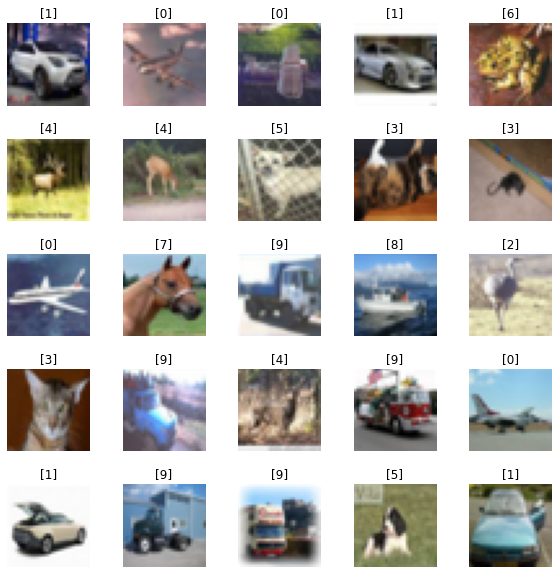

In [4]:
W_grid=5
L_grid=5
fig,axes = plt.subplots(L_grid,W_grid,figsize=(10,10))
axes=axes.ravel()
n_training=len(x_train)
for i in np.arange(0,L_grid * W_grid):
    index=np.random.randint(0,n_training) 
    axes[i].imshow(x_train[index])
    axes[i].set_title(y_train[index]) 
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.4)

In [5]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

In [6]:
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 1))
((15000, 32, 32, 3), (15000, 1))
((10000, 32, 32, 3), (10000, 1))


In [7]:
y_train=tf.keras.utils.to_categorical(y_train)
y_val=tf.keras.utils.to_categorical(y_val)
y_test=tf.keras.utils.to_categorical(y_test)

In [8]:
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 10))
((15000, 32, 32, 3), (15000, 10))
((10000, 32, 32, 3), (10000, 10))


In [9]:
train_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1 )

val_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip=True,
                                    zoom_range=.1)

test_generator = ImageDataGenerator(
                                    rotation_range=2, 
                                    horizontal_flip= True,
                                    zoom_range=.1) 

In [10]:
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

In [11]:
base_model = VGG16(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])

2021-12-07 09:35:39.601477: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-12-07 09:35:39.921530: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:e1:00.0 name: RTX A5000 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 64 deviceMemorySize: 23.69GiB deviceMemoryBandwidth: 715.34GiB/s
2021-12-07 09:35:39.921577: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-12-07 09:35:39.923420: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-12-07 09:35:39.923456: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-12-07 09:35:39.924378: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2021

In [12]:
model= Sequential()
model.add(base_model) 
model.add(Flatten()) 

In [13]:
model.add(Dense(1024,activation=('relu'),input_dim=512))
model.add(Dense(512,activation=('relu'))) 
model.add(Dense(256,activation=('relu'))) 
model.add(Dense(128,activation=('relu')))
model.add(Dense(10,activation=('softmax'))) #This is the classification layer
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1

In [25]:
from tensorflow.keras.optimizers import SGD

batch_size= 32
epochs=50
learn_rate=.005

sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)

In [26]:
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
model.fit(train_generator.flow(x_train,y_train,batch_size=batch_size),
                      epochs=epochs,
                      steps_per_epoch=x_train.shape[0]//batch_size,
                      validation_data=val_generator.flow(x_val,y_val,batch_size=batch_size),
                      verbose=1)

Epoch 1/50
1093/1093 [==============================] - 19s 17ms/step - loss: 0.5083 - accuracy: 0.8433 - val_loss: 0.7338 - val_accuracy: 0.7787
Epoch 2/50
1093/1093 [==============================] - 20s 18ms/step - loss: 0.4195 - accuracy: 0.8711 - val_loss: 0.5747 - val_accuracy: 0.8261
Epoch 3/50
1093/1093 [==============================] - 19s 17ms/step - loss: 0.3796 - accuracy: 0.8797 - val_loss: 0.5936 - val_accuracy: 0.8217
Epoch 4/50
1093/1093 [==============================] - 18s 17ms/step - loss: 0.3319 - accuracy: 0.8974 - val_loss: 0.5752 - val_accuracy: 0.8385
Epoch 5/50
1093/1093 [==============================] - 18s 17ms/step - loss: 0.3043 - accuracy: 0.9060 - val_loss: 0.6418 - val_accuracy: 0.8095
Epoch 6/50
1093/1093 [==============================] - 20s 18ms/step - loss: 0.2797 - accuracy: 0.9128 - val_loss: 0.6352 - val_accuracy: 0.8159
Epoch 7/50
1093/1093 [==============================] - 19s 17ms/step - loss: 0.2535 - accuracy: 0.9216 - val_loss: 0.6158 -

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
metrics = pd.DataFrame(model.history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,1.639803,0.396794,1.033571,0.642867
1,0.897622,0.694110,0.838372,0.719000
2,0.685013,0.769471,0.635645,0.782933
3,0.578656,0.801990,0.591680,0.800667
4,0.505194,0.828028,0.553954,0.812267
5,0.438405,0.847786,0.542667,0.811133
6,0.387809,0.865594,0.549678,0.821600
7,0.350403,0.879101,0.537453,0.826800
8,0.312959,0.890224,0.573599,0.817933
9,0.272170,0.905053,0.509566,0.837533


Text(0.5, 0, 'Epoch')

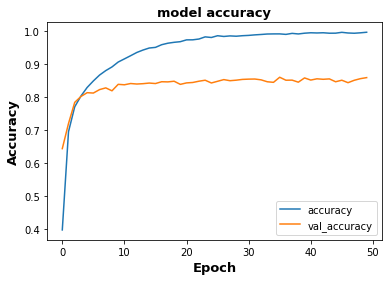

In [18]:
metrics[['accuracy', 'val_accuracy']].plot()
plt.title("model accuracy",fontweight='bold',fontsize=13)
plt.ylabel("Accuracy",fontweight='bold',fontsize=13)
plt.xlabel("Epoch",fontweight='bold',fontsize=13)

Text(0.5, 0, 'Epoch')

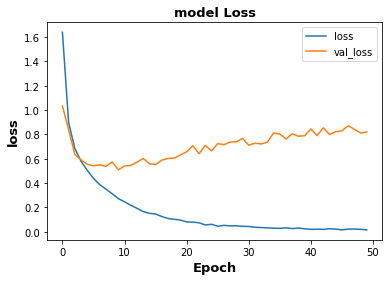

In [19]:
metrics[['loss', 'val_loss']].plot()
plt.title("model Loss",fontweight='bold',fontsize=13)
plt.ylabel("loss",fontweight='bold',fontsize=13)
plt.xlabel("Epoch",fontweight='bold',fontsize=13)

In [20]:
y_predict = np.argmax(model.predict(x_test), axis=-1)
y_true=np.argmax(y_test,axis=1)

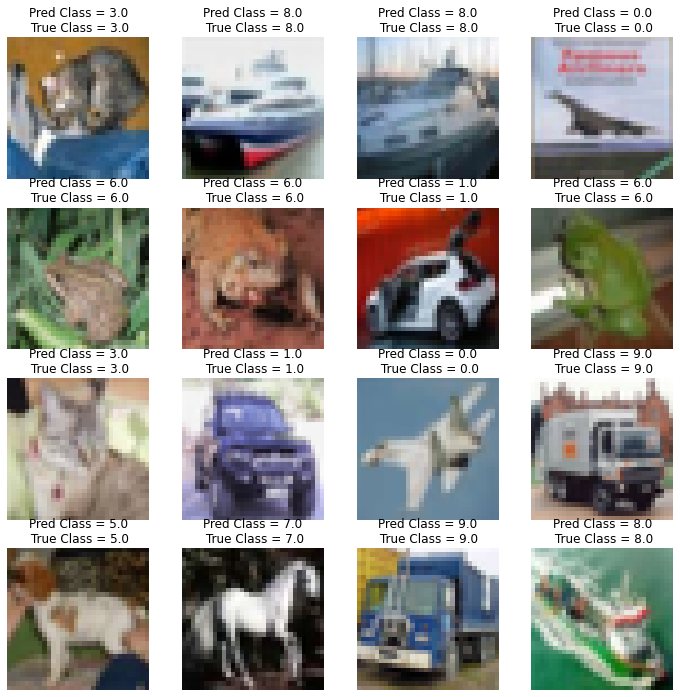

In [21]:
L = 4
W = 4
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    axes[i].imshow(x_test[i])
    axes[i].set_title(f"Pred Class = {y_predict[i]:0.1f}\n True Class = {y_true[i]:0.1f}")
    axes[i].axis('off')